In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import pytomography
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform, GaussianFilter
from pytomography.metadata import SPECTObjectMeta, SPECTProjMeta
from pytomography.projectors import SPECTSystemMatrix
from pytomography.io.SPECT import simind, dicom
from pytomography.metadata import SPECTPSFMeta
from pytomography.algorithms import OSEM

Data can be downloaded from here:
https://drive.google.com/drive/folders/1TjXU9XiYVTjlUI1U-h7t91RyjWeUn1q-?usp=share_link

In [2]:
download_path = r'C:\Users\lukep\Documents\PhD Stuff\Pytomography\youtube_tutorial_data'

# PyTomography

The present focus of PyTomography is image reconstruction in SPECT imaging. What is meant by "reconstruction"?

<p align="center">
  <img src="../images/spectdiagram.png" alt="drawing" width="700" align="center"/>
</p>

* $f(x,y,z)$ is the radioactivity concentration everywhere in space (measured in Bequerels or "number of radioactive decays per second")
* $g(r,z,\theta)$ is the number of counts detected by the detector at the pixel $(r,z)$ when the detector is rotated at angle $\theta$

In any imaging system, one measures $g$ and wants to "reconstruct" $f$. In otherwords, we want to go $g \to f$.

It turns out, in order to do this, we first need a "model" of the imaging system $f \to g$ (an easier problem). How can we do this?
* Write a Monte Carlo simulation that models photon transport and the detector, simulate emission distribution based on $f(x,y,z)$, and get $g$. In practice, this is computationally expensive.
* Derive an analytical model for the imaging system: $g = Hf$

It can be shown under normal conditions that $H$ is a linear operator (i.e. if I image two organs seperately and add those scans together, its the same as if I image both at the same time). Since $H$ is a linear operator (and $g$ and $f$ are finite dimensional objects), $H$ can be represented by a matrix, known as the **system matrix**. 

## Part 1: System Modeling

First, lets open a basic 3D distribution representing the radioactivity of a patient.

In [4]:
from scipy.ndimage import zoom
f_truth = np.fromfile(os.path.join(download_path, 'body1_Lu177_T1_temp.bin'), dtype=np.float32).reshape(768,512,512)
f_truth = zoom(f_truth, (0.5,0.25,0.25), order=1)
f_truth = np.transpose(f_truth, (2,1,0))
f_truth *= 8000 / f_truth.sum()

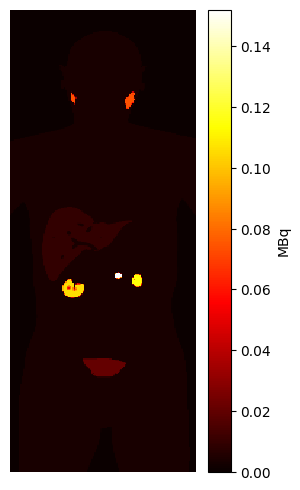

In [9]:
plt.figure(figsize=(3,6))
plt.pcolormesh(f_truth[:,64].T, cmap='hot') 
plt.axis('off')
plt.colorbar(label='MBq')
plt.show()

The units of each voxel are in MBq, so many "decays" occur per second. In general, not all of these decays emit a photon, and not all photons are detected (most get absorbed by the collimator, others simply miss the detector). A detector typically has a calibration factor in units of CPS/MBq where CPS=counts per second

In [10]:
calibration_factor = 10 #counts, per second, per MBq

So if we scan at each angle for 15 seconds, we can scale our image accordingly:

In [11]:
time_per_projection = 15
f_truth_scaled = f_truth * calibration_factor * time_per_projection

Now are image can be thought to have units of "counts emitted which are detected"

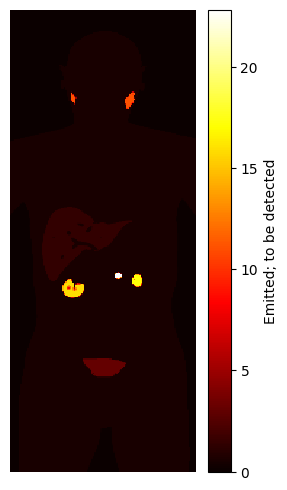

In [12]:
plt.figure(figsize=(3,6))
plt.pcolormesh(f_truth_scaled[:,64].T, cmap='hot') 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.show()

In reality, these counts follow a Poisson distribution, so we need to generate noise:

In [13]:
f_truth_scaled_noise = np.random.poisson(f_truth_scaled)

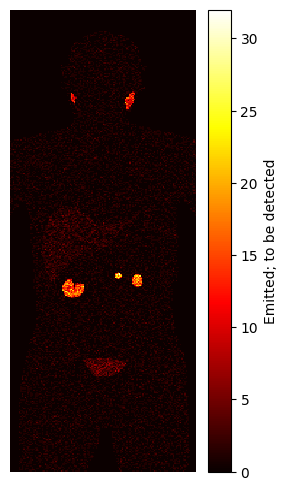

In [14]:
plt.figure(figsize=(3,6))
plt.pcolormesh(f_truth_scaled_noise[:,64].T, cmap='hot') 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.show()

This represents the counts that will be emitted in a voxel during the acquisition period of a single detector position (10 second measurement). To see what the detected image will look like, we use PyTomography

* **Part 1**: Define relevant physical parameters

In [15]:
object_meta = SPECTObjectMeta(dr=(0.3,0.3,0.3), shape=f_truth_scaled_noise.shape)
proj_meta = SPECTProjMeta(projection_shape=f_truth_scaled_noise.shape[1:], angles=[0.,20.,40.], radii=[15.,15.,15.])

* Part 2: Define system matrix. For now, we'll use a very basic model (we'll model real SPECT phenomena shortly). This system model $H$ merely rotates $f$ by a given angle, and sums along a given axis to simulate "parallel" projection.

In [18]:
system_matrix = SPECTSystemMatrix(obj2obj_transforms=[],
                                  proj2proj_transforms=[],
                                  object_meta=object_meta,
                                  proj_meta=proj_meta)

In [21]:
f_input = torch.tensor(f_truth_scaled_noise).unsqueeze(0).to(pytomography.device).to(pytomography.dtype)

In [23]:
g = system_matrix.forward(f_input)

In [25]:
g.shape

torch.Size([1, 3, 128, 384])

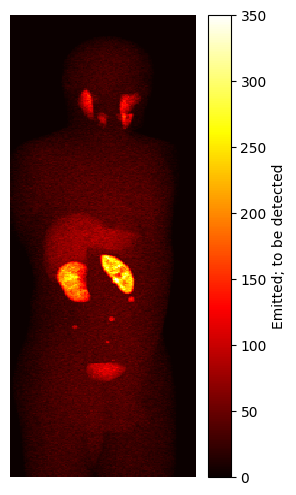

In [28]:
plt.figure(figsize=(3,6))
plt.pcolormesh(g[0,2].cpu().T, cmap='hot') 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.show()

In reality, system modeling of SPECT is slightly more complicated. There's two important factors that need to be taken into account

1. **Attenuation Correction**: Not all photons "make it out of the body" to be detected. Some get absorbed, and some scatter in a different direction
2. **Collimator Detector Response Modeling**: While the collimator keeps photons entering mostly perpendicular to the detector, some enter at an angle. This can be accounted for by applying blurring to the 3D object $f$ before summation along an axis.

Attenuation correction requires knowing the attenuation coefficient everywhere in space. Thankfully, this is what a CT scan can give us. Lets load our attenuation map:

In [29]:
attenuation_map = simind.get_attenuation_map(os.path.join(download_path, 'body1.hct'))

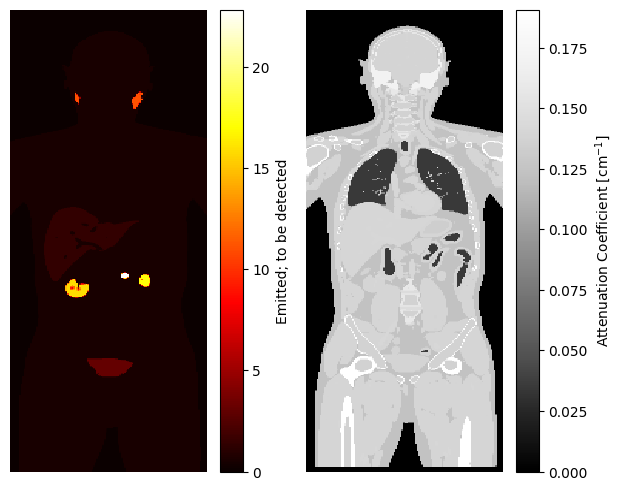

In [30]:
plt.subplots(1,2,figsize=(7,6))
plt.subplot(121)
plt.pcolormesh(f_truth_scaled[:,64].T, cmap='hot') 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.subplot(122)
plt.pcolormesh(attenuation_map.cpu()[0][:,64].T, cmap='Greys_r') 
plt.axis('off')
plt.colorbar(label='Attenuation Coefficient [cm$^{-1}$]')
plt.show()

The attenuation coefficient gives the probability of attenuation along the photon path: $p=e^{-\int\mu(x) dx}$ where $\mu$ is the attenuation coefficient. We can combine this in our system matrix to make the forward projection take this into account

In [31]:
attenuation_transform = SPECTAttenuationTransform(attenuation_map)
system_matrix_attenuating = SPECTSystemMatrix(obj2obj_transforms=[attenuation_transform],
                                  proj2proj_transforms=[],
                                  object_meta=object_meta,
                                  proj_meta=proj_meta)

In [32]:
g_attenuated = system_matrix_attenuating.forward(f_input)

We can compare this to the other projections:

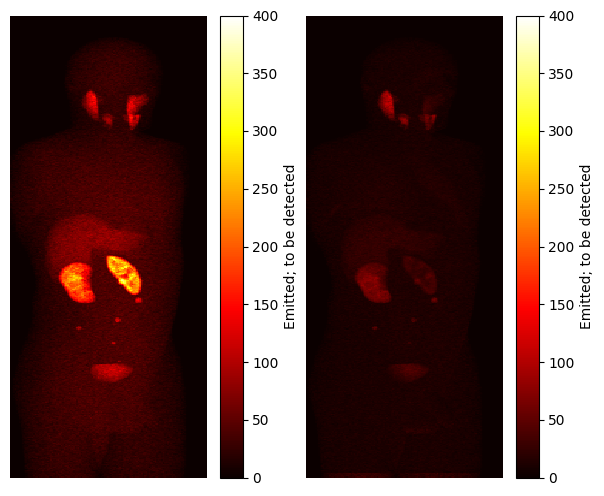

In [33]:
plt.subplots(1,2,figsize=(7,6))
plt.subplot(121)
plt.pcolormesh(g[0,2].cpu().T, cmap='hot', vmax=400) 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.subplot(122)
plt.pcolormesh(g_attenuated[0,2].cpu().T, cmap='hot', vmax=400) 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.show()

Note that there are significantly less counts that get detected.

Collimator detector response modeling accounts for the fact that not all photons travel exactly perpendicular to the detector when they get detected. In the diagram below, only the solid lines get detected (but they aren't always perpendicular)

<p align="center">
  <img src="../images/spect_col.png" alt="drawing" width="300" align="center"/>
</p>

As such, we need proper CDR modeling that depends on the collimator geometry itself. We can choose a Siemens Medium Energy (designed for medium energy photon SPECT detection) assuming the photons we are detecting are 208keV as follows:

In [34]:
psf_meta = dicom.get_psfmeta_from_scanner_params('SY-ME', energy_keV=208)
psf_transform = SPECTPSFTransform(psf_meta)

Now we can build a system matrix that accounts for both attenuation and PSF modeling:

In [36]:
system_matrix_full = SPECTSystemMatrix(obj2obj_transforms=[attenuation_transform, psf_transform],
                                  proj2proj_transforms=[],
                                  object_meta=object_meta,
                                  proj_meta=proj_meta)

In [37]:
g_full = system_matrix_full.forward(f_input)

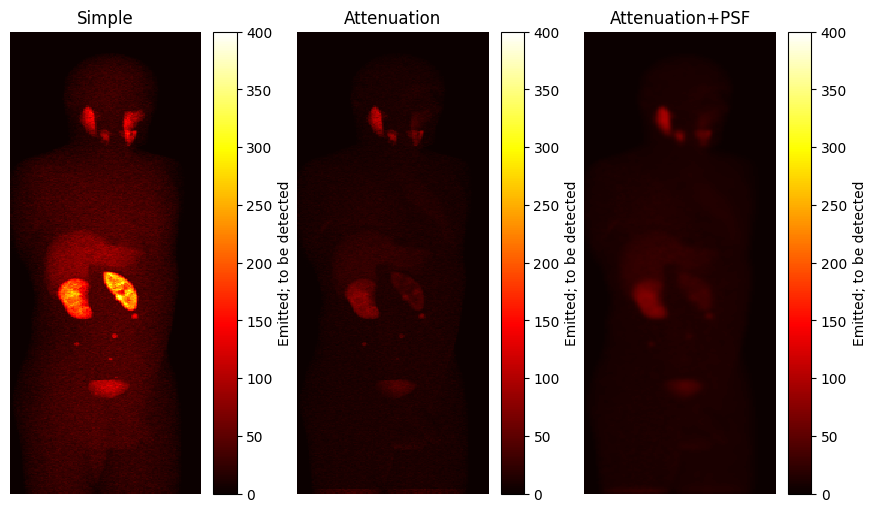

In [38]:
plt.subplots(1,3,figsize=(10.5,6))
plt.subplot(131)
plt.pcolormesh(g[0,2].cpu().T, cmap='hot', vmax=400) 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.title('Simple')
plt.subplot(132)
plt.pcolormesh(g_attenuated[0,2].cpu().T, cmap='hot', vmax=400) 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.title('Attenuation')
plt.subplot(133)
plt.pcolormesh(g_full[0,2].cpu().T, cmap='hot', vmax=400) 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.title('Attenuation+PSF')
plt.show()

Note the image is now blurred. In essence, we now have a full system matrix $H$ that accurately measures the data $g$ we would expect under $g=Hf$.

Because $H$ was implemented as a linear operator, we also have access to its transpose, $H^T$. This will be important in reconstruction algorithms. Note that $H^T \neq H^{-1}$ so we can't go from $g$ back to $f$ with it.

In [39]:
f_backward = system_matrix_full.backward(g_full)

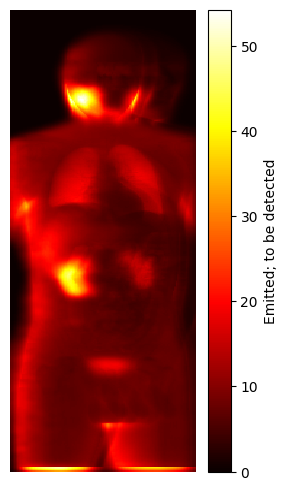

In [42]:
plt.figure(figsize=(3,6))
plt.pcolormesh(f_backward[0][:,74].cpu().T, cmap='hot') 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.show()

Note that back projection doesn't immediately yield anything useful (but $H^T$ will play an important piece in reconstruction algorithms)

# Reconstruction Algorithms

So far, we've considered $f$ and asked what $g$ would I expect to get under a system matrix $H$, we then promptly simulated $g=Hf$ using the modeling functionality.

In reality, one measures $g$ and develops a model for $H$ and wants to get an estimate for what $f$ could have been. A reconstruction algorithm $A$ works as follows:

$$\hat{f} = A(g, H, ...)$$

where $\hat{f}$ is an estimate for the object $f$ that produced $g$ under $H$. There are many different reconstruction algorithms and the literature on them is extensive: here we will focus on the main clinically used one: OSEM. There are tutorials for the other availble ones on the webpage. OSEM produces an estimate as follows:

$$\hat{f}^{n,m+1} = \left[\frac{1}{H_m^T 1} H_m^T \left(\frac{g_m}{H_m\hat{f}^{n,m}+s}\right)\right] \hat{f}^{n,m}$$

In this equation, $m$ specifies a subset of projections (typical SPECT scan has about 120 total, one might split into 8 subsets of size 15 each) and $n$ represents the iteration number. $s$ represents an estimate for scatter (we'll ignore scatter here for now, and assume its 0' we'll deal with it later). In this case, $H_m$ only forward projects to the specified subset of projections, while $H_m^T$ back projects from that subset. Furthermore $\hat{f}^{n+1,0}\equiv\hat{f}^{n,M}$ where $M$ is the last subset.

In [43]:
object_meta = SPECTObjectMeta(dr=(0.3,0.3,0.3), shape=f_truth_scaled_noise.shape)
proj_meta = SPECTProjMeta(projection_shape=f_truth_scaled_noise.shape[1:], angles=np.linspace(0,360,120), radii=np.ones(120)*15.)
attenuation_transform = SPECTAttenuationTransform(attenuation_map)
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms=[attenuation_transform, psf_transform],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta=proj_meta)
g = system_matrix.forward(f_input)

Now we can create the reconstruction algorithm:

In [44]:
recon_algorithm = OSEM(projections=g, system_matrix=system_matrix)

And run for the specified number of iterations/subsets:

In [45]:
f_recon = recon_algorithm(n_iters=10, n_subsets=8)

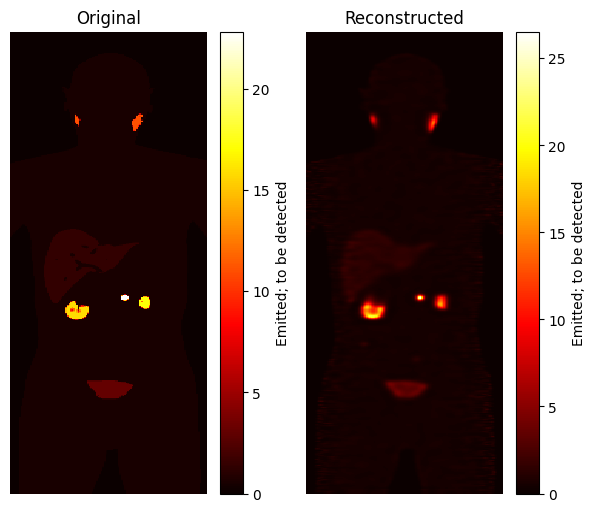

In [46]:
plt.subplots(1,2,figsize=(7,6))
plt.subplot(121)
plt.pcolormesh(f_truth_scaled[:,64].T, cmap='hot') 
plt.axis('off')
plt.title('Original')
plt.colorbar(label='Emitted; to be detected')
plt.subplot(122)
plt.pcolormesh(f_recon.cpu()[0][:,64].T, cmap='hot') 
plt.axis('off')
plt.colorbar(label='Emitted; to be detected')
plt.title('Reconstructed')
plt.show()

In this example, we used the modeling of PyTomography to create our image $g$. In reality, this image $g$ is obtained by a real detector (though we still need the modeling capabilities of $H$ for our reconstruction algorithm). We'll now look at two different examples of obtaining image data $g$

## Case 1: Monte Carlo Simulation

The SIMIND Monte Carlo program is used to take input data $f$ and obtain an image estimate $g$ using Monte Carlo simulation by individually tracking each photon, and simulating the detector. This model consitutes something resembling physical reality (and our analytical system matrix $H$ is meant to simulate it).

* Monte Carlo modeling only models forward projection $Hf$. There is no concept of $H^T$ for photon tracking, which is needed for reconstruction.

The following will be a data that represents simulation of a "liver" shaped object:

In [67]:
projections_path = os.path.join(download_path, 'photopeak.h00')
object_meta, proj_meta = simind.get_metadata(projections_path)
projections = simind.get_projections(projections_path)

In [68]:
projections.shape

torch.Size([1, 120, 128, 384])

The units of SIMIND data are in counts per second per MBq. To get units of counts, we must scale by the total activity and measured time per projection. Note that the data format of SIMIND therefore allows us to simulate multiple noise realizations of the same scan for different activity/time settings

In [69]:
activity = 100 # MBq
time_per_projection = 15 #s
projections = torch.poisson(activity * time_per_projection * projections)

Let's examine some sample projection angles obtain using SIMIND:

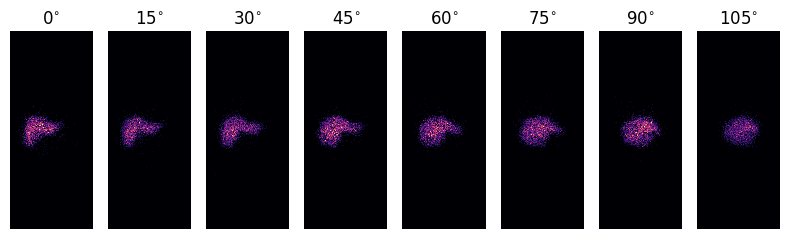

In [70]:
sample_projections = projections[0,::5].cpu().numpy()
sample_angles = proj_meta.angles[::5]
fig, axes = plt.subplots(1,8,figsize=(8,2.5))
for i, ax in enumerate(axes):
    ax.pcolormesh(sample_projections[i].T, cmap='magma')
    ax.set_title(f'{sample_angles[i]:.0f}'+r'$^{\circ}$')
    ax.axis('off')
fig.tight_layout()

Earlier, I had mentioned that we did not account for scatter. Scattering in SPECT leads to the detection of events that come from incorrect lines of response:

<p align="center">
  <img src="../images/spect_scatter.png" alt="drawing" width="300" align="center"/>
</p>

In the image above, the photon (purple) travels and scatter off some attenuating material (perhaps inside the patient) and becomes aligned such that it enters the detector perpendicularily. The dotted line represents where one would infer the photon came from. This essentially leads to false positive events. There are a few ways to correct for these events: one way is to estimate events that only come from scatter (call this image $s$) and include it in the reconstruction algorithm above.

* One way of obtaining this estimate is the triple energy window technique, which uses detected photon events from upper and lower energy windows to estimate scatter

In [71]:
upperscatter_path = os.path.join(download_path, 'lowerscatter.h00')
lowerscatter_path = os.path.join(download_path, 'upperscatter.h00')

In [72]:
scatter = simind.get_scatter_from_TEW(
    headerfile_peak = projections_path,
    headerfile_lower = lowerscatter_path,
    headerfile_upper = upperscatter_path
)
scatter = torch.poisson(scatter * activity * time_per_projection)

Now we can view the estimated scatter:

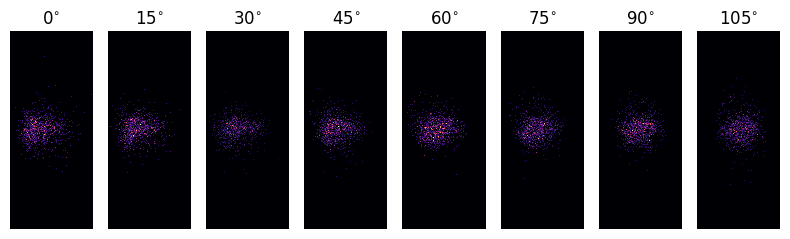

In [73]:
sample_projections = scatter[0,::5].cpu().numpy()
sample_angles = proj_meta.angles[::5]
fig, axes = plt.subplots(1,8,figsize=(8,2.5))
for i, ax in enumerate(axes):
    ax.pcolormesh(sample_projections[i].T, cmap='magma')
    ax.set_title(f'{sample_angles[i]:.0f}'+r'$^{\circ}$')
    ax.axis('off')
fig.tight_layout()

Like before, we need to build the system matrix $H$ in order to reconstruct. We will employ attenuation correction and PSF modeling like before. For attenuation correction, we load an attenuation map provided by SIMIND. For PSF modeling, we use the collimator information provided by the projection header file:

In [82]:
# Attenuation
attenuation_path = os.path.join(download_path, 'body1.hct')
attenuation_map = simind.get_attenuation_map(attenuation_path)
att_transform = SPECTAttenuationTransform(attenuation_map)
# PSF
psf_meta = simind.get_psfmeta_from_header(projections_path)
psf_transform = SPECTPSFTransform(psf_meta)

Now we can build our system matrix:

In [83]:
system_matrix = SPECTSystemMatrix(obj2obj_transforms=[att_transform, psf_transform],
                                  proj2proj_transforms=[],
                                  object_meta=object_meta,
                                  proj_meta=proj_meta)

And reconstruct like before (now giving the scatter data to correct for scatter):

In [84]:
recon_algorithm = OSEM(projections=projections, system_matrix=system_matrix, scatter=scatter)
f_recon = recon_algorithm(n_iters=10, n_subsets=8)

Sometimes it is desirable to smooth a 3D reconstructed image post reconstruction. We can do this using a a gaussian filter:

In [85]:
post_smoothing_filter = GaussianFilter(1) # 1cm full-width half max
post_smoothing_filter.configure(object_meta,proj_meta)
f_recon_smoothed = post_smoothing_filter(f_recon)

From this we can view our reconstructed liver (along with the attenuation map)

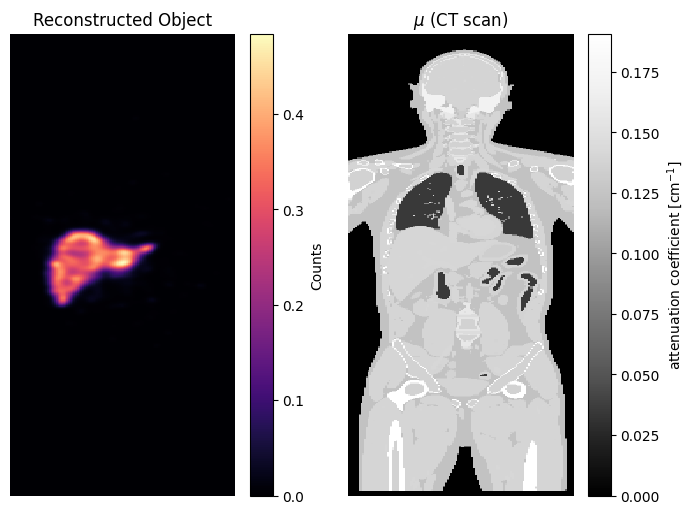

In [87]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(f_recon_smoothed[0].cpu()[:,64].T, cmap='magma')
plt.colorbar(label='Counts')
plt.axis('off')
plt.title('Reconstructed Object')
plt.subplot(122)
plt.pcolormesh(attenuation_map.cpu()[0][:,64].T, cmap='Greys_r')
plt.colorbar(label='attenuation coefficient [cm$^{-1}$]')
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()

## Case 2: Clinical Data

Of course, the real point behind this is to reconstruct real clinical data of patient scans. So far, we've looked at $g$ obtained through (i) PyTomography internal system matrix modeling and (ii) Monte Carlo simulation. Now it's time to turn to $g$ obtained using a real scanner, from a real patient.

It's VERY hard to get access to open source clinical data. Thankfully, there is such a repository for SPECT data here:
https://deepblue.lib.umich.edu/data/concern/data_sets/dn39x173n?locale=en

We'll reconstruct this data to get a 3D activity map of a patient.

In [88]:
projections_path = os.path.join(download_path, 'patient_projections', '2.16.840.1.114362.1.11979141.22403444876.563074960.959.1972.dcm')
object_meta, proj_meta = dicom.get_metadata(projections_path)
projections = dicom.get_projections(projections_path, index_peak=0)
scatter = dicom.get_scatter_from_TEW(projections_path, index_peak=0, index_lower=1, index_upper=2)

Lets view the projections (this is a scan of the chest cavity of a patient):

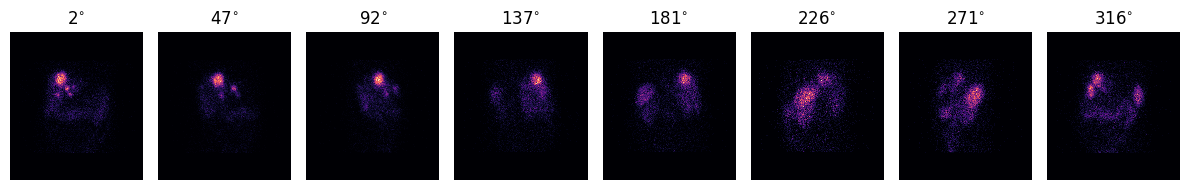

In [89]:
sample_projections = projections[0,::15].cpu().numpy()
sample_angles = proj_meta.angles[::15]
fig, axes = plt.subplots(1,8,figsize=(12,2))
for i, ax in enumerate(axes):
    ax.pcolormesh(sample_projections[i].T, cmap='magma')
    ax.set_title(f'{sample_angles[i]:.0f}'+r'$^{\circ}$')
    ax.axis('off')
fig.tight_layout()

This represents a scan from a real patient. Let's set up the system matrix like before. In this case, we'll build the attenuation map from a CT scan, which requires converting from CT units to cm$^{-1}$ AND aligning the CT data with the projections (automatically done by PyTomography) 

In [93]:
path_CT = os.path.join(download_path, 'patient_ct')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
attenuation_map = dicom.get_attenuation_map_from_CT_slices(file_NM=projections_path, files_CT=files_CT, index_peak=0)
att_transform = SPECTAttenuationTransform(attenuation_map)

The PSF metadata requires specifying the photon energy / collimator configuration used in the scan (in this case, $E=208$keV because the scan was Lu177, and the collimator used was Siemens Medium Energy)

In [94]:
psf_meta = dicom.get_psfmeta_from_scanner_params('SY-ME', energy_keV=208)
psf_transform = SPECTPSFTransform(psf_meta)

Now we can build the system matrix, and the reconstruction algorithm:

In [95]:
system_matrix = SPECTSystemMatrix(
    obj2obj_transforms=[att_transform, psf_transform],
    proj2proj_transforms=[],
    object_meta=object_meta,
    proj_meta=proj_meta)

Now lets build the reconstruction algorithm and reconstruct:

In [96]:
recon_algorithm = OSEM(projections=projections, system_matrix=system_matrix, scatter=scatter)
f_recon = recon_algorithm(n_iters=5, n_subsets=8)

Finally, lets view the reconstructed object next to the obtained attenuation map (CT)

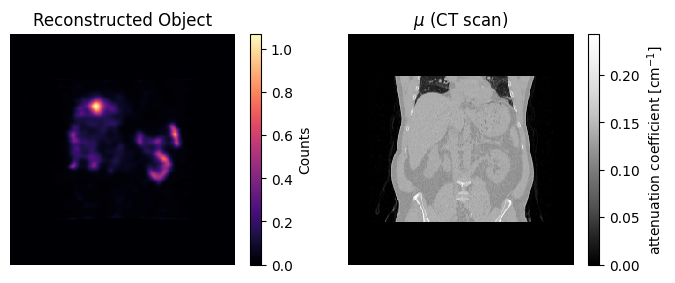

In [97]:
plt.subplots(1,2,figsize=(8,3))
plt.subplot(121)
plt.pcolormesh(f_recon[0].cpu()[:,128].T, cmap='magma')
plt.colorbar(label='Counts')
plt.axis('off')
plt.title('Reconstructed Object')
plt.subplot(122)
plt.pcolormesh(attenuation_map.cpu()[0][:,128].T, cmap='Greys_r')
plt.colorbar(label='attenuation coefficient [cm$^{-1}$]')
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()

In this tutorial, we only looked at the very basic OSEM algorithm. There are many more advanced ones in the tutorials section of the website (the focus of my research)!

* https://pytomography.readthedocs.io/en/latest/usage.html